#**COMP4211** **Project**
Code for the project in COMP4211, Sentiment analysis of Hotel Reviews using SVM and XGBClassifier

Group members:
* Shahir Imam, SID: 21077367
* Batmanaman, SID: 20855968


#1. Setup
Mount drive with the dataset and import important libraries for the preprocessing

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###1.1 Imports

In [ ]:
# 1. Imports Data Preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from datetime import datetime

# 2. Imports tokenization and lemmatization
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus.reader.wordnet import VERB, NOUN, ADJ, ADV

  # Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

  # Set of English stopwords
stop_words = set(stopwords.words('english'))

# 3. Imports vectorization and training
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss,  make_scorer, f1_score
from sklearn.preprocessing import LabelEncoder

# imports for
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


###1.2 Clean and remove null values and duplicates

In [ ]:
# Find the dataset
path = '/content/drive/My Drive/COMP4211 project/mussorie_reviews.csv'

df = pd.read_csv(path)

# Clean the data
df.dropna(inplace = True) # remove null values
df.drop_duplicates(inplace = True) # remove duplicates

df.head(3)
# 17595 values removed

Review  \
0  Most beautiful stay at Mussoorie...such a gorg...   
2  The Savoy is one of those rare hotels that not...   
4  Def Best stay in Uttarakand ! Amazing nature. ...   

                  Date of stay  \
0    Date of stay: August 2021   
2   Date of stay: October 2020   
4  Date of stay: November 2021   

                                             Rating  
0  <span class="ui_bubble_rating bubble_50"></span>  
2  <span class="ui_bubble_rating bubble_50"></span>  
4  <span class="ui_bubble_rating bubble_50"></span>

In [ ]:
# Create a cleaner dataframe with all the data
reviews_df = pd.DataFrame({'Review' : df['Review'],
                       'Rating' : df['Rating'].str.extract('bubble_(\d)', expand=False).astype(int),
                       'Month of stay' : df['Date of stay'].str.extract('Date of stay: (\w+)', expand=False),
                       'Year' : df['Date of stay'].str.extract('(\d{4})$', expand = False)
})

reviews_df = reviews_df.reset_index(drop = True)
reviews_df.head(3)

Review  Rating Month of stay  \
0  Most beautiful stay at Mussoorie...such a gorg...       5        August   
1  The Savoy is one of those rare hotels that not...       5       October   
2  Def Best stay in Uttarakand ! Amazing nature. ...       5      November   

   Year  
0  2021  
1  2020  
2  2021

# 2. Data Exploration and Preprocessing

##2.1 Data Analysis
Checking the proportions of the data

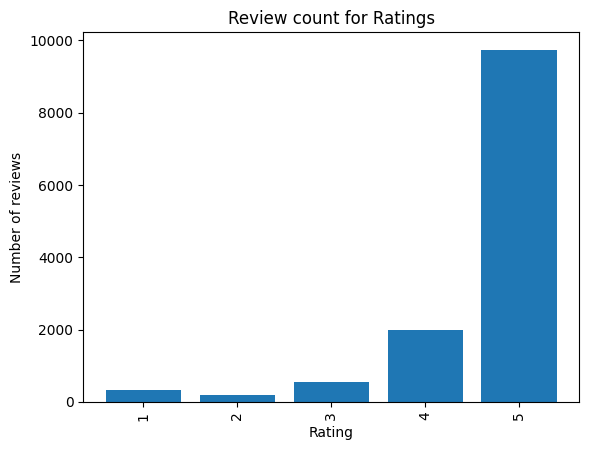

Proportions of ratings: 
 Rating
5    0.761175
4    0.155048
3    0.043295
1    0.024695
2    0.015786
Name: proportion, dtype: float64


In [ ]:
# Distributions of the ratings
star_counts = reviews_df["Rating"].value_counts().sort_index(ascending = True)
plt.bar(star_counts.index, star_counts.values)
plt.xlabel('Rating')
plt.ylabel('Number of reviews')
plt.title('Review count for Ratings')
plt.xticks(rotation=90)
plt.show()
print("Proportions of ratings: \n",reviews_df["Rating"].value_counts(normalize = True))

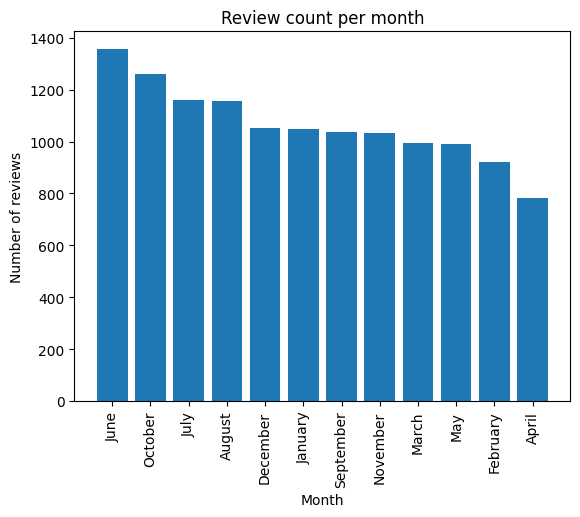

In [ ]:
# Bar plot of the months
month_counts = reviews_df['Month of stay'].value_counts()
plt.bar(month_counts.index, month_counts.values)
plt.xlabel('Month')
plt.ylabel('Number of reviews')
plt.title('Review count per month')
plt.xticks(rotation=90)
plt.show()

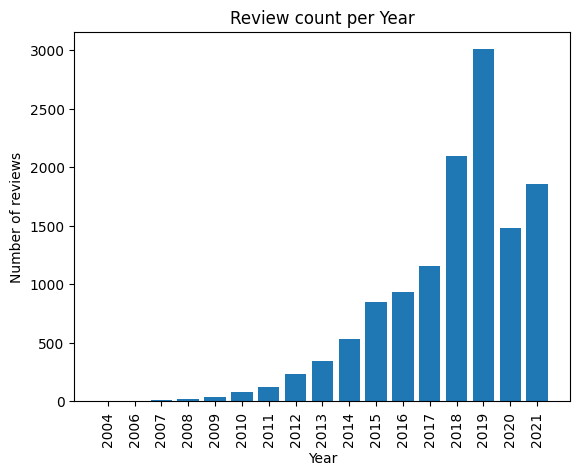

In [ ]:
# Bar plot of the years
year_counts = reviews_df['Year'].value_counts().sort_index(ascending=True)
plt.bar(year_counts.index, year_counts.values)
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.title('Review count per Year')
plt.xticks(rotation=90)
plt.show()


* We see that that the data is very imbalanced in the ratings. The reviews heavily favour the positive rating 5 with very few being below 4.

* We see that hte highest amount of reviews were received in the month of June while the least were received in April. It seems to be fairly balanced around 1100 reviews per month with June and April being outliers.

* The review count were increasing until 2019, which is the year with the most reviews. Then we have a reasonable drop in 2020 which can easily be explained with the outbreak of the coronavirus.


##2.2 Processing the Reviews
* Tokenizing - splitting up the reviews into words
* Removing stopwords - removing words that do not bring anything to the sentiment like "the, and, a"
* Lemmatization - transforming the words into their base form "running" -> "run"

####2.2.1 Function to preprocess the textual reviews
* Input - Reviews
* Output - String of words from the reviews removing stopwords and lemmatizing the words

In [ ]:
# Tokenize and Lemmatize the reviews

# Function to convert NLTK's POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return ADJ
    elif tag.startswith('V'):
        return VERB
    elif tag.startswith('N'):
        return NOUN
    elif tag.startswith('R'):
        return ADV
    else:
        return NOUN

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to process the reviews: tokenize, remove stopwords, POS-tag, and lemmatize
def preprocess_reviews(review):
    # Tokenize the review
    tokens = word_tokenize(review)
    # tag POS
    tagged_tokens = pos_tag(tokens)
    # Remove stopwords and non-alphabetic words, then lemmatize with correct POS
    lemmatized_words = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(pos_tag))
                         for word, pos_tag in tagged_tokens
                         if word.isalpha() and word.lower() not in stop_words]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

# Adding the processed review to our dataframe
reviews_df['Processed_Review'] = reviews_df['Review'].apply(preprocess_reviews)


###2.2.2 Mapping sentiments to ratings
Sentiments are mapped to the ratings given by every reviewer, where ratings 5 and 4 are seen as positive, 3 as neutral and 2 and 1 as negative.  

In [ ]:
# Mapping positive, neutral and negative to rating values
reviews_df["Sentiment"] = reviews_df["Rating"].map({5:"Positive", 4:"Positive", 3:"Neutral", 2:"Negative", 1:"Negative"})
#reviews_df = reviews_df[reviews_df['Sentiment'] != 'Neutral'] # Remove Neutral reviews

# Label the sentiments
reviews_df['Sentiment'] = LabelEncoder().fit_transform(reviews_df['Sentiment'])

print(reviews_df['Sentiment'].unique())

# Create a new dataset with only the necessary data for training
processed_reviews_df = reviews_df[['Processed_Review','Sentiment','Month of stay']]

[2 0 1]


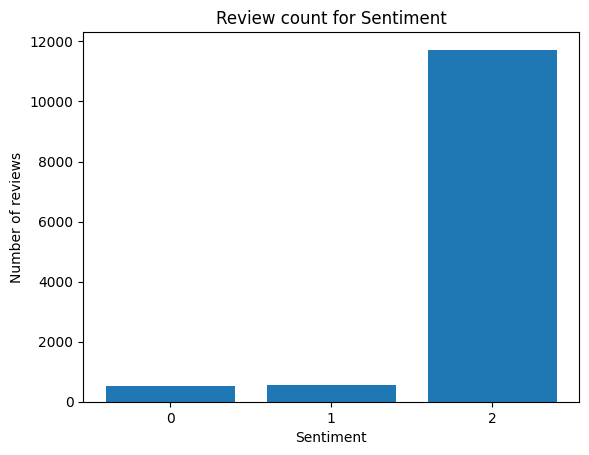

In [ ]:
# Distributions of the sentiment
star_counts = reviews_df["Sentiment"].value_counts().sort_index(ascending = True)
plt.bar(star_counts.index, star_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Number of reviews')
plt.title('Review count for Sentiment')
plt.xticks([0, 1, 2],rotation=0)
plt.show()

##2.3 Exploring the processed data
###2.3.1 Presenting the most common words in the reviews as wordclouds

In [ ]:
# Removing the two most frequent words
# 'room' and 'hotel' from the reviews
processed_reviews_df.loc[:,"Processed_Review"] = processed_reviews_df["Processed_Review"].apply(lambda x: " ".join([word for word in str(x).split() if word not in ['room','hotel']]))

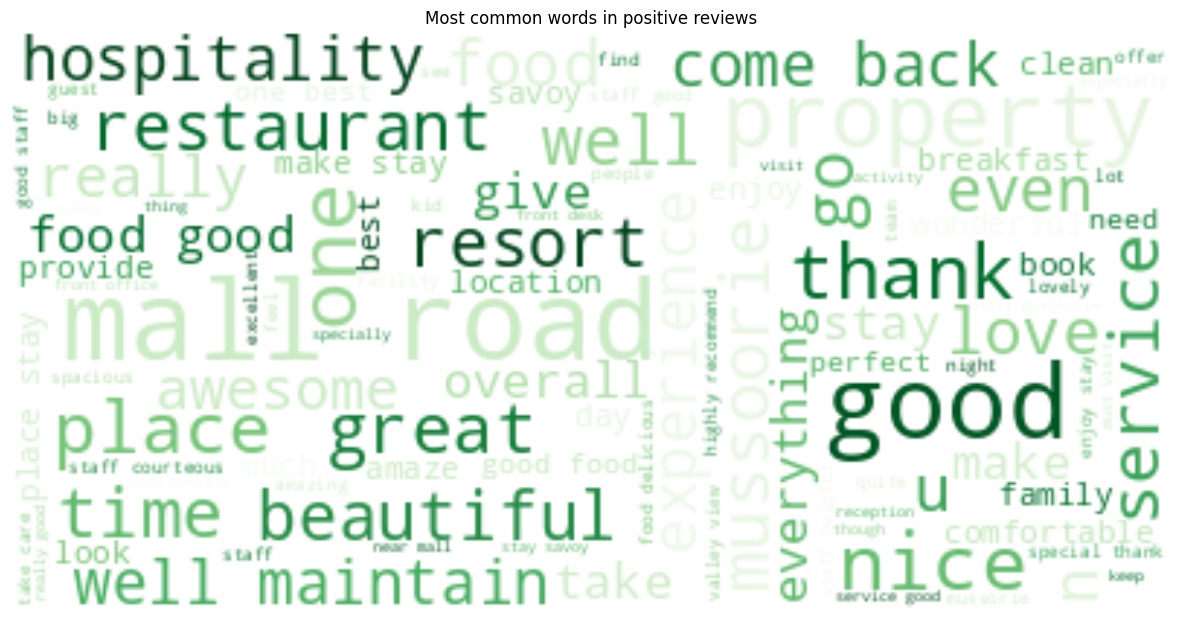

In [ ]:
# Plotting a wordcloud for positive reviews
positive = " ".join(review for review in processed_reviews_df["Processed_Review"][processed_reviews_df['Sentiment']==2])
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=500, max_font_size=38, random_state=4211, colormap='Greens').generate(positive)
plt.figure(figsize=(15, 10))
plt.title("Most common words in positive reviews")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

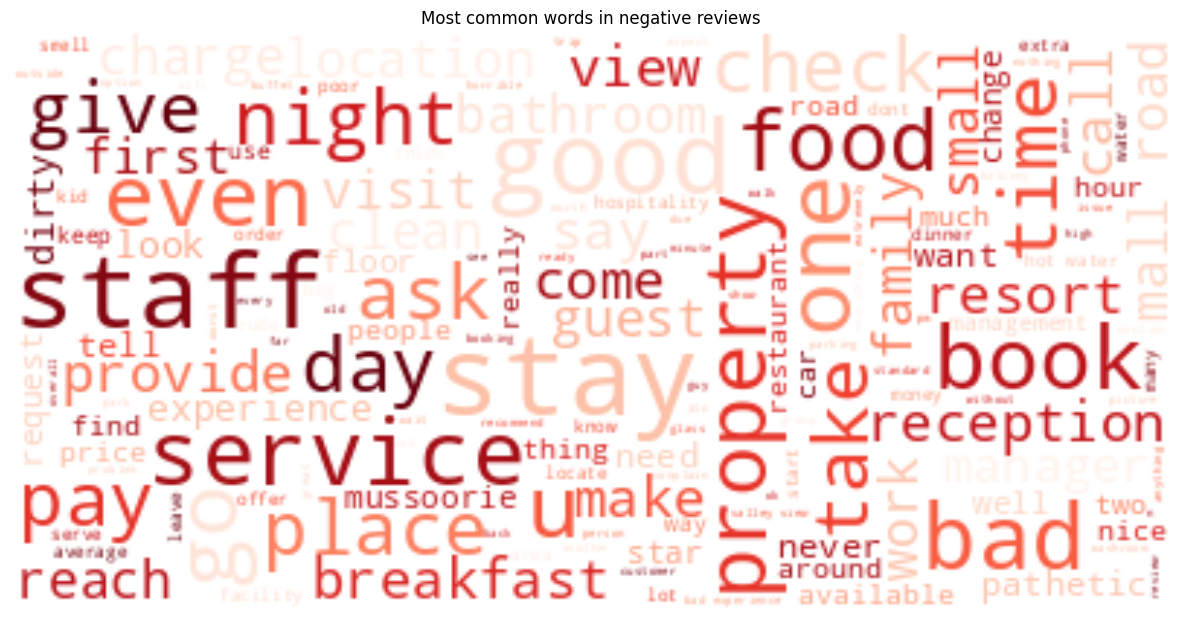

In [ ]:
# Plotting wordcloud for negative reviews
negative = " ".join(review for review in  processed_reviews_df["Processed_Review"][processed_reviews_df['Sentiment']==0])
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=500, max_font_size=38, random_state=4211, colormap = "Reds").generate(negative)
plt.figure(figsize=(15, 10))
plt.title("Most common words in negative reviews")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

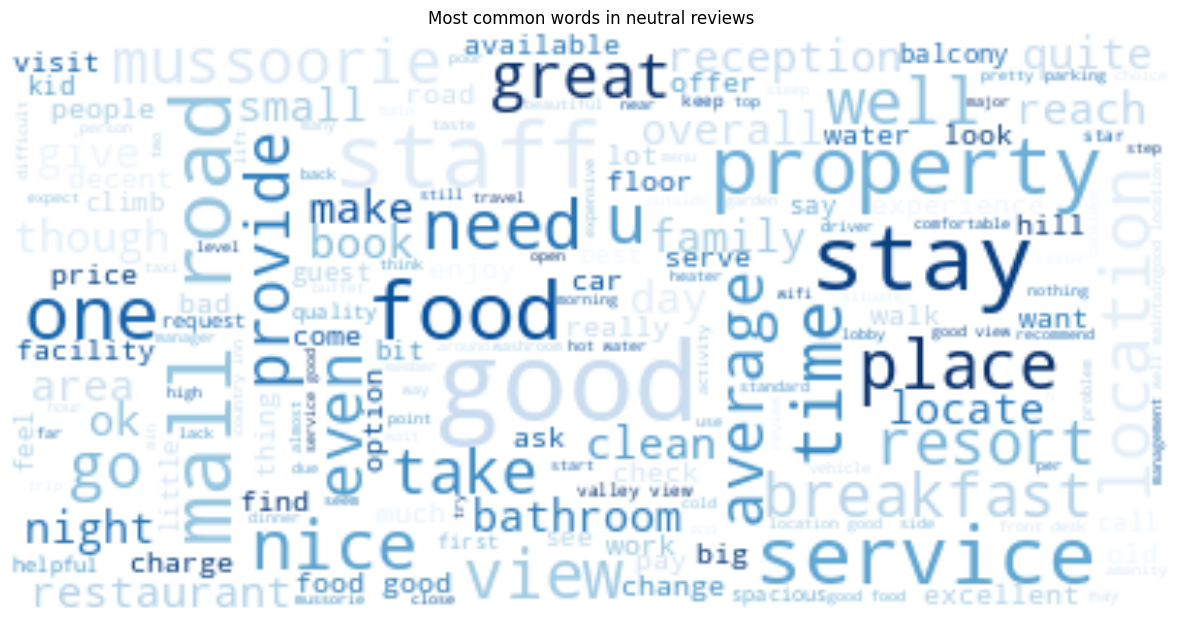

In [ ]:
# Plotting wordcloud for neutral reviews
neutral = " ".join(review for review in processed_reviews_df["Processed_Review"][processed_reviews_df['Sentiment']==1])
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=500, max_font_size=38, random_state=4211, colormap = "Blues").generate(neutral)
plt.figure(figsize=(15, 10))
plt.title("Most common words in neutral reviews")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

###2.3.2 Data analysis on the months


In [ ]:
# group the data
grouped_df = processed_reviews_df.groupby(['Month of stay', 'Sentiment']).size().unstack(fill_value=0)

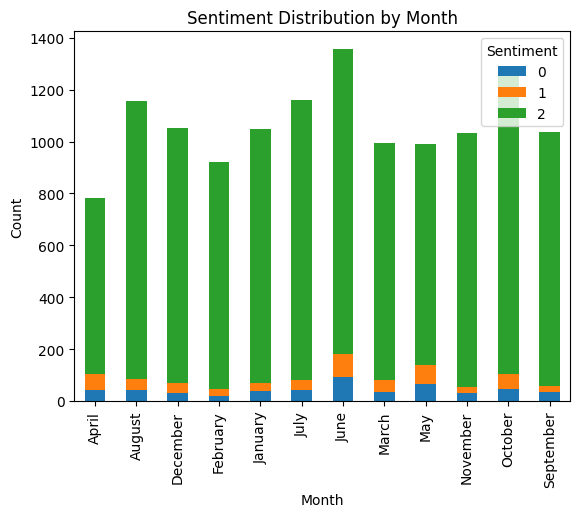

In [ ]:
grouped_df.plot(kind='bar', stacked=True)
# Customize the plot
plt.title('Sentiment Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Sentiment')

# Show the plot
plt.show()

We split the dataset according to the warmth of the months as:
*   Hotter months: April, May, June, July, August, September
* Colder months: January, February, March, October, November, December

All according to monthly temperature data in Mussorie, India: https://en.climate-data.org/asia/india/uttarakhand/mussoorie-24772/, we see there is a big difference in average temperature in these two datasets. The goal is to see if there is a difference in the reviews depending on the weather or temperature.

In [ ]:
# Split the dataset into hotter and colder depending on the months
hotter_months = ['April', 'May', 'June', 'July', 'August', 'September']
colder_months = ['October', 'November','December', 'January', 'February', 'March']

#hotter season
hot_df = processed_reviews_df[processed_reviews_df['Month of stay'].isin(hotter_months)].reset_index(drop = True)
#hot_df['Sentiment'] = LabelEncoder().fit_transform(hot_df['Sentiment'])
sentiments_hot = hot_df['Sentiment']

#colder seasons
cold_df = processed_reviews_df[processed_reviews_df['Month of stay'].isin(colder_months)].reset_index(drop = True)
#cold_df['Sentiment'] = LabelEncoder().fit_transform(cold_df['Sentiment'])
sentiments_cold = cold_df['Sentiment']

hot_df.head(3)

Processed_Review  Sentiment Month of stay
0  beautiful stay mussoorie gorgeous property rea...          2        August
1  superb hospitality superb stay itc welcome loo...          2     September
2  find option yash guided walk via savoy stroke ...          2     September

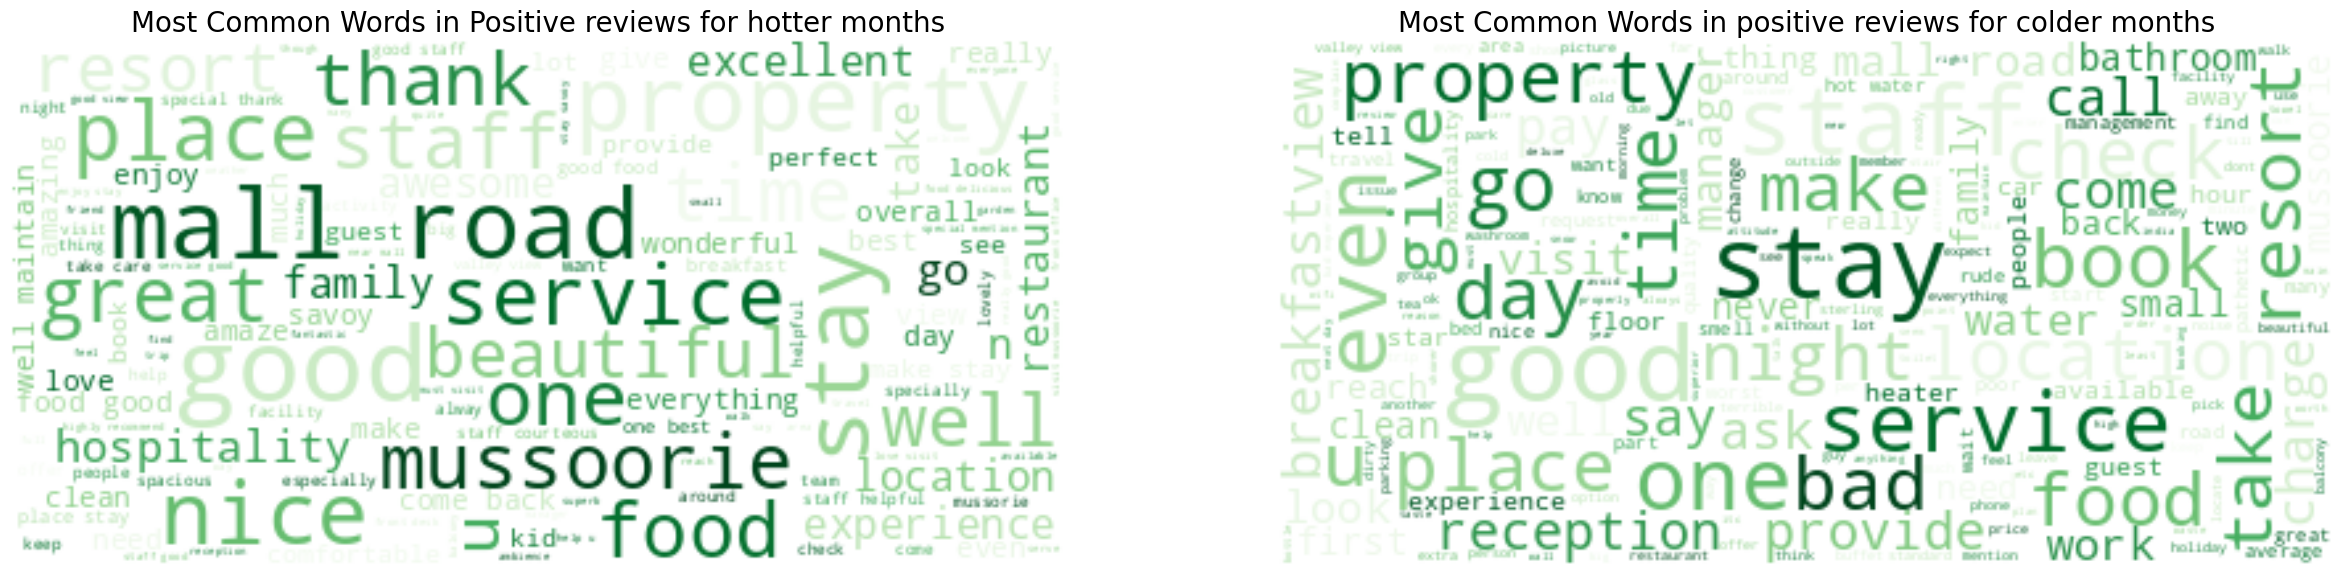

In [ ]:
# Create word clouds for positive reviews in hotter and colder seasons
# hot positive reviews
pos_hot = " ".join(review for review in hot_df['Processed_Review'][hot_df['Sentiment']==2])
wordcloud_hot = WordCloud(background_color='white', stopwords=STOPWORDS, max_words=500, max_font_size=40, random_state=4211, colormap='Greens').generate(pos_hot)

# cold positive reviews
pos_cold = " ".join(review for review in cold_df['Processed_Review'][cold_df['Sentiment']==0])
wordcloud_cold = WordCloud(background_color='white', stopwords=STOPWORDS, max_words=500, max_font_size=40, random_state=4211, colormap='Greens').generate(pos_cold)

plt.figure(figsize=(30, 15))

# Plotting the hot reviews word cloud
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(wordcloud_hot, interpolation='bilinear')
plt.title('Most Common Words in Positive reviews for hotter months', size=20)
plt.axis("off")

# Plotting the cold reviews word cloud
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(wordcloud_cold, interpolation='bilinear')
plt.title('Most Common Words in positive reviews for colder months', size=20)
plt.axis("off")

# Show the plot
plt.show()

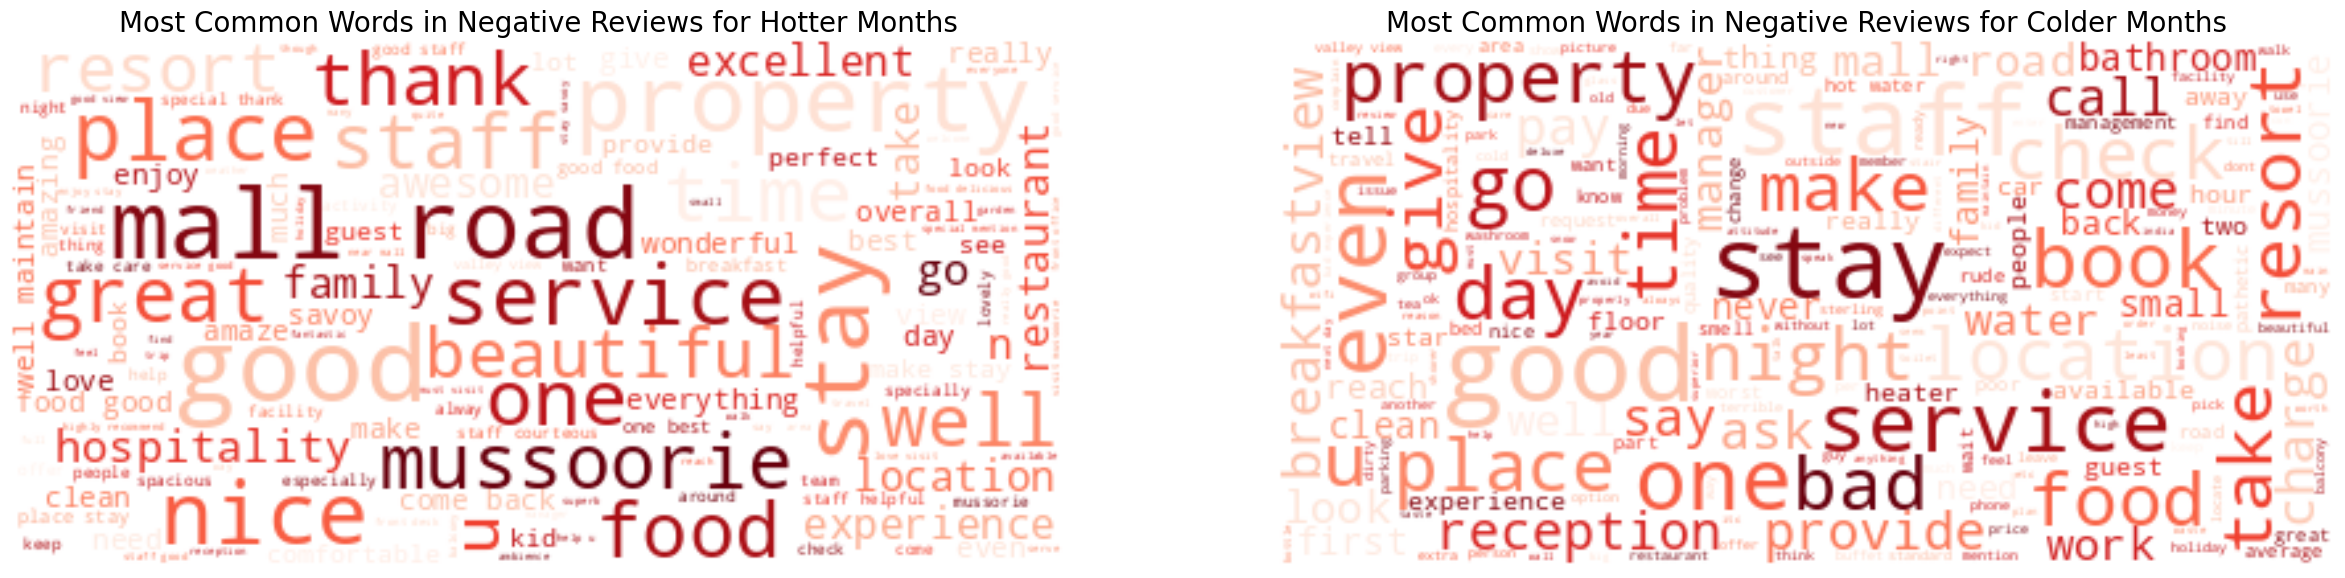

In [ ]:
# Create word clouds for negative reviews in hotter and colder seasons
# hot negative reviews
neg_hot = " ".join(review for review in hot_df['Processed_Review'][hot_df['Sentiment']==2])
wordcloud_hot = WordCloud(background_color='white', stopwords=STOPWORDS, max_words=500, max_font_size=40, random_state=4211, colormap='Reds').generate(neg_hot)

# cold negative reviews
neg_cold = " ".join(review for review in cold_df['Processed_Review'][cold_df['Sentiment']==0])
wordcloud_cold = WordCloud(background_color='white', stopwords=STOPWORDS, max_words=500, max_font_size=40, random_state=4211, colormap='Reds').generate(neg_cold)

plt.figure(figsize=(30, 15))

# Plotting the hot reviews word cloud
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(wordcloud_hot, interpolation='bilinear')
plt.title('Most Common Words in Negative Reviews for Hotter Months', size=20)
plt.axis("off")

# Plotting the cold reviews word cloud
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(wordcloud_cold, interpolation='bilinear')
plt.title('Most Common Words in Negative Reviews for Colder Months', size=20)
plt.axis("off")

# Show the plot
plt.show()

#3. Model Training

##3.1 Prepare data for training
* Splitting
* Vectorization

In [ ]:
# Prepare data for training
reviews = processed_reviews_df['Processed_Review']
sentiments = processed_reviews_df['Sentiment']

# Split the data into training and testing sets
# Train data = 80%, Test data = 20%
X_train, X_test, y_train, y_test = train_test_split(reviews, sentiments, test_size=0.2, random_state=4211, stratify=sentiments, shuffle=True)

# Initialize the TF-IDF Vectorizer
# parameters: min_df - words have to appear at least 10 times, max_df - if words appear in more than 80 % of reviews it will be removed
tfidf_vectorizer = TfidfVectorizer(min_df=10, max_df=0.8, max_features=None,
                                   stop_words = 'english',analyzer='word', ngram_range=(1, 3), sublinear_tf=1)

# Fit and transform the processed reviews
X_train_tfv = tfidf_vectorizer.fit_transform(X_train)
X_test_tfv = tfidf_vectorizer.transform(X_test)

# Feature names and TF-IDF matrix shape
feature_names = tfidf_vectorizer.get_feature_names_out()
print("Feature names:", feature_names[10:20])  # print a slice of feature names
print("TF-IDF Matrix shape:", X_train_tfv.shape)

Feature names: ['ac' 'accept' 'access' 'access mall' 'access mall road' 'accessibility'
 'accessible' 'accommodate' 'accommodation' 'accomodate']
TF-IDF Matrix shape: (10236, 6174)


## 3.2 SVM model
Creating the Support Vector Machine (SVM) model

###3.2.1 Training
Training the model with the train dataset

In [ ]:

# Initialize and train the SVM model
svm_model = SVC()#kernel='linear')#, class_weight={0: 7.5, 1: 7.5, 2: 1}, C=0.1) # using the best parameters found
svm_model.fit(X_train_tfv, y_train)

SVC()

###3.2.2 Evaluate the Model

Accuracy Score:
0.940625
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.61      0.73       104
           1       0.40      0.02      0.03       111
           2       0.94      1.00      0.97      2345

    accuracy                           0.94      2560
   macro avg       0.75      0.54      0.58      2560
weighted avg       0.92      0.94      0.92      2560



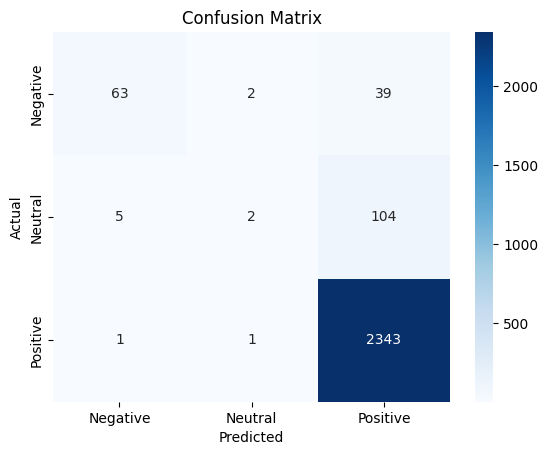

In [ ]:
# Predict the sentiments on the testing set
y_pred = svm_model.predict(X_test_tfv)

# Evaluate the model
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate and visualize the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral', 'Positive'], yticklabels=['Negative','Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

The model performed poorly on the neutral reviews as seen in the f1 score for "1", it performed fairly decent on the negative reviews while performing very good on the positive reviews. This can be explained by the amount of data the model was trained on. Since there are significantly more positive reviews the model can predict with higher accuracy.

###3.2.3 Hypertuning SVM
We hypertune with the intent of having the highest average f1 score since our goal is to be able to predict the different sentiments with high accuracy. By just using accuracy the model tends to specialize in positive reviews and predicts them with almost perfect accuracy, which makes the total accuracy higher since the amount of positive reviews are significantly higher.

In [ ]:
neutral_f1_scorer = make_scorer(f1_score, pos_label=1,average='macro')

param_grid = {
    'C': [0.1, 0.5, 1],
    'kernel': ['linear'],
    'class_weight': ['balanced',{0: 5, 1: 5, 2: 1},{0: 7.5, 1: 7.5, 2: 1}]
}

grid = GridSearchCV(SVC(), param_grid, refit=True,scoring=neutral_f1_scorer, cv=3, verbose=3)
grid.fit(X_train_tfv, y_train)

print(f"Best parameters found: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END C=0.1, class_weight={0: 10, 1: 10, 2: 1}, kernel=linear;, score=0.657 total time=  15.0s
[CV 2/3] END C=0.1, class_weight={0: 10, 1: 10, 2: 1}, kernel=linear;, score=0.691 total time=  14.4s
[CV 3/3] END C=0.1, class_weight={0: 10, 1: 10, 2: 1}, kernel=linear;, score=0.673 total time=  14.3s
[CV 1/3] END C=1, class_weight={0: 10, 1: 10, 2: 1}, kernel=linear;, score=0.620 total time=   7.9s
[CV 2/3] END C=1, class_weight={0: 10, 1: 10, 2: 1}, kernel=linear;, score=0.653 total time=   7.3s
[CV 3/3] END C=1, class_weight={0: 10, 1: 10, 2: 1}, kernel=linear;, score=0.634 total time=   7.8s
[CV 1/3] END C=2, class_weight={0: 10, 1: 10, 2: 1}, kernel=linear;, score=0.599 total time=   6.8s
[CV 2/3] END C=2, class_weight={0: 10, 1: 10, 2: 1}, kernel=linear;, score=0.642 total time=   7.3s
[CV 3/3] END C=2, class_weight={0: 10, 1: 10, 2: 1}, kernel=linear;, score=0.621 total time=   6.7s
[CV 1/3] END C=10, class_weight={0


##3.3 XGBClassifier
Create the XGBClassifier model

###3.3.1 Training and Evaluating the model

In [ ]:
# Initializing XGBClassifier
xgb_model = XGBClassifier(learning_rate=0.02, n_estimators=600, max_depth=4, subsample= 1.0, min_child_weight=1, gamma= 0.5, colsample_bytree= 0.8, random_state=4211)

# Fitting xgb on training dataset
xgb_model.fit(X_train_tfv, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Accuracy Score:
0.93671875
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.50      0.60       104
           1       0.44      0.11      0.17       111
           2       0.95      1.00      0.97      2345

    accuracy                           0.94      2560
   macro avg       0.72      0.53      0.58      2560
weighted avg       0.92      0.94      0.92      2560



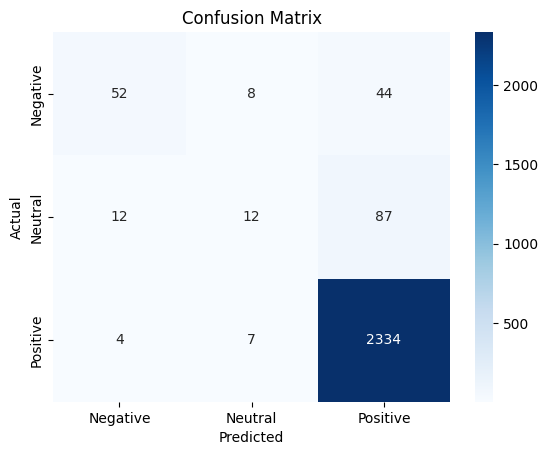

In [ ]:
# Predict the sentiments on the testing set
y_pred = xgb_model.predict(X_test_tfv)

# Evaluate the model
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate and visualize the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral', 'Positive'], yticklabels=['Negative','Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

###3.3.3 Hypertuning XGB

ADD class weights

In [ ]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, max_depth=4, subsample= 1.0, min_child_weight=1, gamma= 0.5, colsample_bytree= 0.8,
                    class_weight={'negative': 7.5, 'neutral': 7.5, 'positive': 1}, random_state=4211)

xgb.fit(X_train_tfv, y_train)

y_pred_2 = xgb.predict(X_test_tfv)

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_2))

print("Classification Report:")
print(classification_report(y_test, y_pred_2))

Accuracy Score:
0.938671875
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.53      0.63       104
           1       0.48      0.13      0.20       111
           2       0.95      1.00      0.97      2345

    accuracy                           0.94      2560
   macro avg       0.74      0.55      0.60      2560
weighted avg       0.92      0.94      0.92      2560



Best result from tuning paramters manually

Accuracy Score:
0.941796875
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.60      0.67       104
           1       0.44      0.22      0.29       111
           2       0.96      0.99      0.97      2345

    accuracy                           0.94      2560
   macro avg       0.72      0.60      0.65      2560
weighted avg       0.93      0.94      0.93      2560



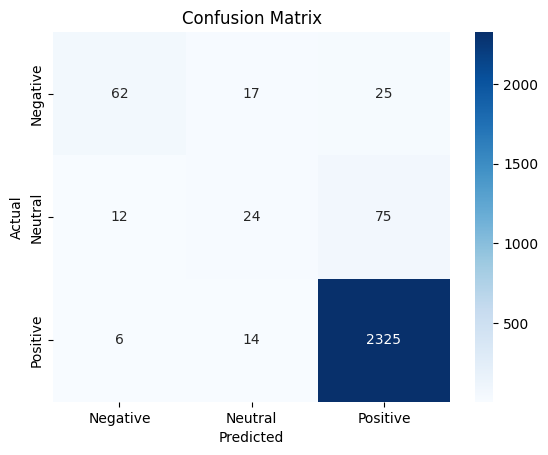

In [ ]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=800, max_depth=6,  min_child_weight=7, gamma= 0.1, colsample_bytree= 0.9,
                    class_weight={0: 7.5, 1: 7.5, 2: 1}, random_state=4211)

xgb.fit(X_train_tfv, y_train)

y_pred = xgb.predict(X_test_tfv)

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate and visualize the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral', 'Positive'], yticklabels=['Negative','Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

using grid search

In [ ]:
param_grid = {
    'learning_rate' : [ 0.1, 0.01],
    'max_depth' : [2, 4, 6],
    'min_child_weight' : [3, 5, 7]
}
classifier = classifier = XGBClassifier( n_estimators=800, gamma= 0.2, colsample_bytree= 0.9, class_weight={'positive': 1, 'neutral': 7.5, 'negative': 7.5} )

grid = GridSearchCV(XGBClassifier(), param_grid, refit = True, scoring = neutral_f1_scorer, cv= 3, verbose = 3)

grid.fit(X_train_tfv, y_train)

print(f"Best parameters found: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END learning_rate=0.1, max_depth=2, min_child_weight=3;, score=0.517 total time=  16.5s
[CV 2/3] END learning_rate=0.1, max_depth=2, min_child_weight=3;, score=0.520 total time=   6.4s
[CV 3/3] END learning_rate=0.1, max_depth=2, min_child_weight=3;, score=0.493 total time=   8.6s
[CV 1/3] END learning_rate=0.1, max_depth=2, min_child_weight=5;, score=0.522 total time=   5.6s
[CV 2/3] END learning_rate=0.1, max_depth=2, min_child_weight=5;, score=0.519 total time=   7.8s
[CV 3/3] END learning_rate=0.1, max_depth=2, min_child_weight=5;, score=0.510 total time=   5.6s
[CV 1/3] END learning_rate=0.1, max_depth=2, min_child_weight=7;, score=0.513 total time=   7.3s
[CV 2/3] END learning_rate=0.1, max_depth=2, min_child_weight=7;, score=0.519 total time=   5.1s
[CV 3/3] END learning_rate=0.1, max_depth=2, min_child_weight=7;, score=0.506 total time=   7.4s
[CV 1/3] END learning_rate=0.1, max_depth=4, min_child_weight=3;, 

##3.5 Predicting sentiment of new reviews

In [ ]:
new_reviews = [
    "The product was great and arrived promptly, loved it!",
    "Terrible customer service, I'm very disappointed.",
    "It's okay, not what I expected but it works.",
    "Absolutely fantastic! Will recommend to everyone.",
    "bad terrible awful never horrible horrific hate abysmal pathethic",
    "We were here in mussoorie for a family holiday and wanted to book a table for meal, we called the hotel 6 times atleast and as soon as we asked the question about the restaurant the receptionist would transfer the call to the restaurant which was never answered and when we called again and told them they took our number and never received a call back, finally when i told the receptionist firmly, she still transferred and the girl who picked up the call and told us told as she wanted check with seniors, we could hear the entire conversation and the her senior said tell them no in a very rude tone. The girl had the audacity to tell us if you want to come tomorrow reserve the table well in advance as you are not staying with us. I am really surprised that when hotels are struggling…",
    "bad small room",
    "good big lovely nice room",
    "very average room",
    "pathethic bad small room poor disgusting pathethic not good i do not like this place"]

negative_reviews = reviews_df[reviews_df['Sentiment'] == 0]
new_reviews2 = negative_reviews.iloc[1:100]['Review']

processed_reviews = [preprocess_reviews(review) for review in new_reviews]

# Convert new reviews to TF-IDF features
new_reviews_tfidf = tfidf_vectorizer.transform(processed_reviews)  # 'tfidf_vectorizer' should be fitted to your training data already

# Predict the sentiments of the new reviews
new_predictions = svm_model.predict(new_reviews_tfidf)

# Display the predictions
print("Predictions for new reviews:")
for review, prediction in zip(new_reviews, new_predictions):
  if prediction == 2:
    print(f"Predicted Sentiment: Positive -- Review: \"{review}\"")
  elif prediction == 1:
    print(f"Predicted Sentiment: Neutral -- Review: \"{review}\"")
  else:
    print(f"Predicted Sentiment: Negative -- Review: \"{review}\"")



Predictions for new reviews:
Predicted Sentiment: Positive -- Review: "The product was great and arrived promptly, loved it!"
Predicted Sentiment: Negative -- Review: "Terrible customer service, I'm very disappointed."
Predicted Sentiment: Neutral -- Review: "It's okay, not what I expected but it works."
Predicted Sentiment: Positive -- Review: "Absolutely fantastic! Will recommend to everyone."
Predicted Sentiment: Negative -- Review: "bad terrible awful never horrible horrific hate abysmal pathethic"
Predicted Sentiment: Negative -- Review: "We were here in mussoorie for a family holiday and wanted to book a table for meal, we called the hotel 6 times atleast and as soon as we asked the question about the restaurant the receptionist would transfer the call to the restaurant which was never answered and when we called again and told them they took our number and never received a call back, finally when i told the receptionist firmly, she still transferred and the girl who picked up th

#4. Training models according to season
We split the dataset according to the warmth of the months as:
*   Hotter months: April, May, June, July, August, September
* Colder months: January, February, March, October, November, December

All according to monthly temperature data in Mussorie: https://en.climate-data.org/asia/india/uttarakhand/mussoorie-24772/, we see there is a big difference in average temperature in these two datasets. The goal is to see if there is a difference in the reviews depending on the weather or temperature.

In [ ]:
print(hot_df.head(3))
print(cold_df.head(3))

                                    Processed_Review  Sentiment Month of stay
0  beautiful stay mussoorie gorgeous property rea...          2        August
1  superb hospitality superb stay itc welcome loo...          2     September
2  find option yash guided walk via savoy stroke ...          2     September
                                    Processed_Review  Sentiment Month of stay
0  savoy one rare justify hype surround far excee...          2       October
1  def best stay uttarakand amazing nature view h...          2      November
2  friendly efficient staff love mention staff ha...          2      November


In [ ]:
reviews_hot = hot_df['Processed_Review']
reviews_cold = cold_df['Processed_Review']
# Split the data into training and testing sets for hot and cold
# Train data = 80%, Test data = 20%
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(reviews_hot, sentiments_hot, test_size=0.2, random_state=4211, stratify=sentiments_hot)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(reviews_cold, sentiments_cold, test_size=0.2, random_state=4211, stratify=sentiments_cold)

# Fit and transform the processed reviews
X_train_h_tfv = tfidf_vectorizer.fit_transform(X_train_h)
X_train_c_tfv = tfidf_vectorizer.fit_transform(X_train_c)

X_test_h_tfv = tfidf_vectorizer.transform(X_test_h)
X_test_c_tfv = tfidf_vectorizer.transform(X_test_c)

In [ ]:
# Train hot
svm_model.fit(X_train_h_tfv, y_train_h)

# Train cold
svm_model.fit(X_train_c_tfv, y_train_c)

SVC(C=0.1, class_weight={0: 7.5, 1: 7.5, 2: 1}, kernel='linear')

Accuracy Score hot:
0.9421742482652274
Classification Report hot:
              precision    recall  f1-score   support

           0       0.84      0.71      0.77        65
           1       0.51      0.37      0.43        65
           2       0.96      0.99      0.98      1167

    accuracy                           0.94      1297
   macro avg       0.77      0.69      0.72      1297
weighted avg       0.93      0.94      0.94      1297



<Axes: >

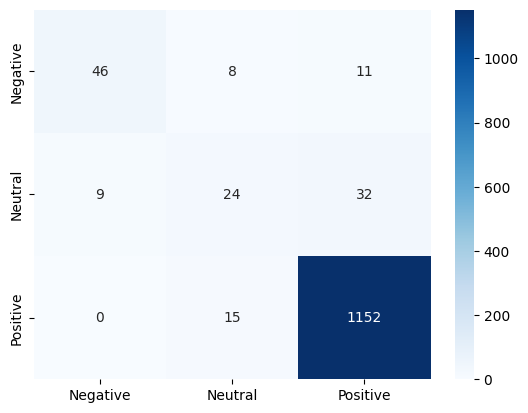

In [ ]:
# Predict the sentiments on the testing set
y_pred_h = svm_model.predict(X_test_h_tfv)

# Evaluate the model
# hot
print("Accuracy Score hot:")
print(accuracy_score(y_test_h, y_pred_h))

print("Classification Report hot:")
print(classification_report(y_test_h, y_pred_h))

conf_mat_hot = confusion_matrix(y_test_h, y_pred_h)
sns.heatmap(conf_mat_hot, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral', 'Positive'], yticklabels=['Negative','Neutral', 'Positive'])


Accuracy Score cold:
0.9469517022961204
Classification Report cold:
              precision    recall  f1-score   support

           0       0.68      0.69      0.68        39
           1       0.41      0.24      0.30        46
           2       0.97      0.98      0.98      1178

    accuracy                           0.95      1263
   macro avg       0.68      0.64      0.65      1263
weighted avg       0.94      0.95      0.94      1263



<Axes: >

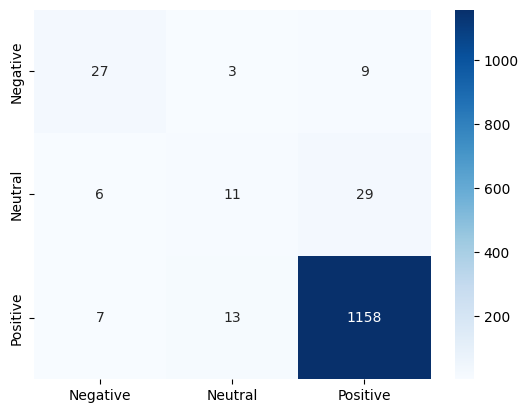

In [ ]:
# cold

# Predict the sentiments on the testing set
y_pred_c = svm_model.predict(X_test_c_tfv)

print("Accuracy Score cold:")
print(accuracy_score(y_test_c, y_pred_c))

print("Classification Report cold:")
print(classification_report(y_test_c, y_pred_c))

conf_mat_cold = confusion_matrix(y_test_c, y_pred_c)
sns.heatmap(conf_mat_cold, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral', 'Positive'], yticklabels=['Negative','Neutral', 'Positive'])


In [ ]:
# Train hot
xgb.fit(X_train_h_tfv, y_train_h)

# Train cold
xgb.fit(X_train_c_tfv, y_train_c)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight={0: 1, 1: 7.5, 2: 7.5}, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.9, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=7, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=800,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Predict the sentiments on the testing set
y_pred_h = xgb.predict(X_test_h_tfv)

# Predict the sentiments on the testing set
y_pred_c = xgb.predict(X_test_c_tfv)

# Evaluate the model
print("Accuracy Score hot:")
print(accuracy_score(y_test_h, y_pred_h))

print("Classification Report hot:")
print(classification_report(y_test_h, y_pred_h))

print("Accuracy Score cold:")
print(accuracy_score(y_test_c, y_pred_c))

print("Classification Report cold:")
print(classification_report(y_test_c, y_pred_c))

Accuracy Score hot:
0.9282960678488821
Classification Report hot:
              precision    recall  f1-score   support

           0       0.73      0.55      0.63        65
           1       0.43      0.14      0.21        65
           2       0.94      0.99      0.97      1167

    accuracy                           0.93      1297
   macro avg       0.70      0.56      0.60      1297
weighted avg       0.91      0.93      0.91      1297

Accuracy Score cold:
0.9493269992082344
Classification Report cold:
              precision    recall  f1-score   support

           0       0.69      0.46      0.55        39
           1       0.65      0.24      0.35        46
           2       0.96      0.99      0.98      1178

    accuracy                           0.95      1263
   macro avg       0.77      0.56      0.63      1263
weighted avg       0.94      0.95      0.94      1263



# **5 Removing netural comments**

According to the word cloud of the neutral comments, it is evident that for 3-stars reviews can easily be considered as postive reviews with only a few negative words.

##5.1 Model on all data

In [ ]:
# Drop neutral reviews
# Remove reviews with sentiment equal to 1
binary_df = reviews_df[reviews_df['Sentiment'] != 1].reset_index(drop = True)

binary_df_hot = hot_df[hot_df['Sentiment'] != 1].reset_index(drop = True)

binary_df_cold = cold_df[cold_df['Sentiment'] != 1].reset_index(drop = True)

In [ ]:
binary_df['Sentiment'] = LabelEncoder().fit_transform(binary_df['Sentiment'])

binary_df_hot['Sentiment'] = LabelEncoder().fit_transform(binary_df_hot['Sentiment'])

binary_df_cold['Sentiment'] = LabelEncoder().fit_transform(binary_df_cold['Sentiment'])

In [ ]:
binary_df_hot['Sentiment'].value_counts()

Sentiment
1    5836
0     323
Name: count, dtype: int64

In [ ]:
# Prepare data for training
reviews = binary_df['Processed_Review']
sentiments = binary_df['Sentiment']

# Split the data into training and testing sets
# Train data = 80%, Test data = 20%
X_train, X_test, y_train, y_test = train_test_split(reviews, sentiments, test_size=0.2, random_state=4211, stratify=sentiments, shuffle=True)

# Fit and transform the processed reviews
X_train_tfv = tfidf_vectorizer.fit_transform(X_train)
X_test_tfv = tfidf_vectorizer.transform(X_test)

In [ ]:
# Fitting svm on training dataset
svm_model2 = SVC(kernel='linear', class_weight='balanced', C=1)
svm_model2.fit(X_train_tfv, y_train)

SVC(C=1, class_weight='balanced', kernel='linear')

In [ ]:
# Predict the sentiments on the testing set
y_pred = svm_model2.predict(X_test_tfv)

# Evaluate the model
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test,y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

Accuracy Score:
0.9918334013883218
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       104
           1       0.99      1.00      1.00      2345

    accuracy                           0.99      2449
   macro avg       0.96      0.94      0.95      2449
weighted avg       0.99      0.99      0.99      2449



<Axes: >

In [ ]:
# Fitting xgb on training dataset
xgb = XGBClassifier(learning_rate=0.1, n_estimators=800, max_depth=6,  min_child_weight=7, gamma= 0.1, colsample_bytree= 0.9, random_state=4211)
xgb.fit(X_train_tfv, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, random_state=4211, ...)

Accuracy Score:
0.9804001633319722
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.62      0.73       104
           1       0.98      1.00      0.99      2345

    accuracy                           0.98      2449
   macro avg       0.94      0.81      0.86      2449
weighted avg       0.98      0.98      0.98      2449



<Axes: >

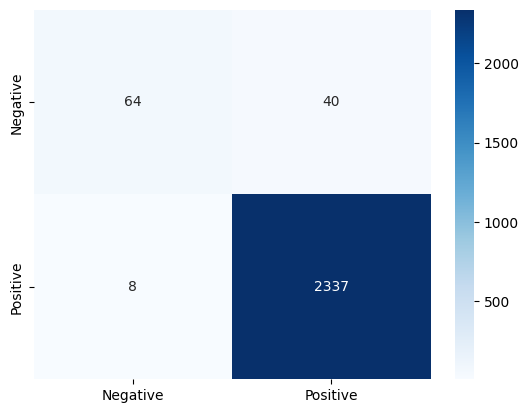

In [ ]:
# Predict the sentiments on the testing set
y_pred = xgb.predict(X_test_tfv)

# Evaluate the model
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test,y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

## 5.2 Model on seasonal data

In [ ]:
reviews_hot = binary_df_hot['Processed_Review']
reviews_cold = binary_df_cold['Processed_Review']

sentiments_hot = binary_df_hot['Sentiment']
sentiments_cold = binary_df_cold['Sentiment']

# Split the data into training and testing sets for hot and cold
# Train data = 80%, Test data = 20%
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(reviews_hot, sentiments_hot, test_size=0.2, random_state=4211, stratify=sentiments_hot)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(reviews_cold, sentiments_cold, test_size=0.2, random_state=4211, stratify=sentiments_cold)

# Fit and transform the processed reviews
X_train_h_tfv = tfidf_vectorizer.fit_transform(X_train_h)
X_train_c_tfv = tfidf_vectorizer.fit_transform(X_train_c)

X_test_h_tfv = tfidf_vectorizer.transform(X_test_h)
X_test_c_tfv = tfidf_vectorizer.transform(X_test_c)

In [ ]:
# Train hot
svm_model2.fit(X_train_h_tfv, y_train_h)

# Train cold
svm_model2.fit(X_train_c_tfv, y_train_c)

SVC(C=1, class_weight='balanced', kernel='linear')

Accuracy Score hot:
0.9853896103896104
Classification Report hot:
              precision    recall  f1-score   support

           0       0.90      0.82      0.85        65
           1       0.99      0.99      0.99      1167

    accuracy                           0.99      1232
   macro avg       0.94      0.91      0.92      1232
weighted avg       0.98      0.99      0.99      1232



<Axes: >

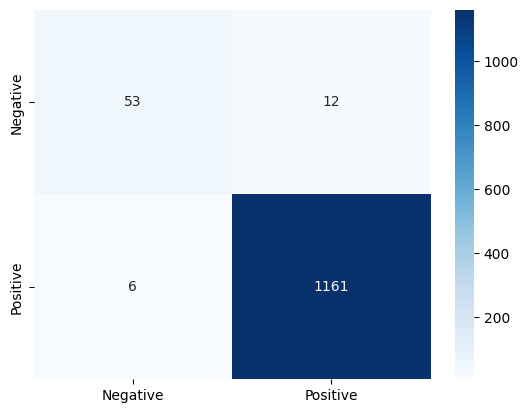

In [ ]:
# Predict the sentiments on the testing set
y_pred_h = svm_model2.predict(X_test_h_tfv)

# Evaluate the model
# hot
print("Accuracy Score hot:")
print(accuracy_score(y_test_h, y_pred_h))

print("Classification Report hot:")
print(classification_report(y_test_h, y_pred_h))

conf_mat_hot = confusion_matrix(y_test_h, y_pred_h)
sns.heatmap(conf_mat_hot, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])


Accuracy Score cold:
0.9827444535743632
Classification Report cold:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73        39
           1       0.99      0.99      0.99      1178

    accuracy                           0.98      1217
   macro avg       0.86      0.85      0.86      1217
weighted avg       0.98      0.98      0.98      1217



<Axes: >

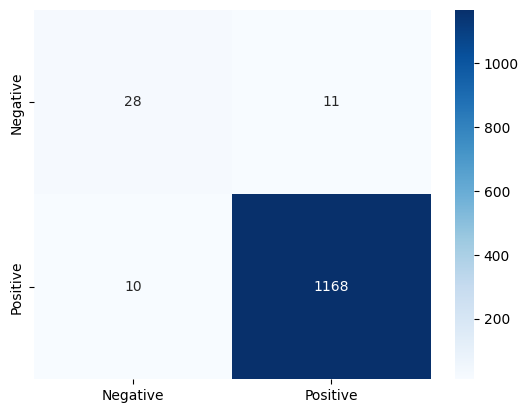

In [ ]:
# Predict the sentiments on the testing set
y_pred_c = svm_model2.predict(X_test_c_tfv)

# Evaluate the model
# hot
print("Accuracy Score cold:")
print(accuracy_score(y_test_c, y_pred_c))

print("Classification Report cold:")
print(classification_report(y_test_c, y_pred_c))

conf_mat_cold = confusion_matrix(y_test_c, y_pred_c)
sns.heatmap(conf_mat_cold, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])


In [ ]:
# Train hot
xgb.fit(X_train_h_tfv, y_train_h)

# Train cold
xgb.fit(X_train_c_tfv, y_train_c)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, random_state=4211, ...)

Accuracy Score hot:
0.9675324675324676
Classification Report hot:
              precision    recall  f1-score   support

           0       0.88      0.45      0.59        65
           1       0.97      1.00      0.98      1167

    accuracy                           0.97      1232
   macro avg       0.92      0.72      0.79      1232
weighted avg       0.97      0.97      0.96      1232



<Axes: >

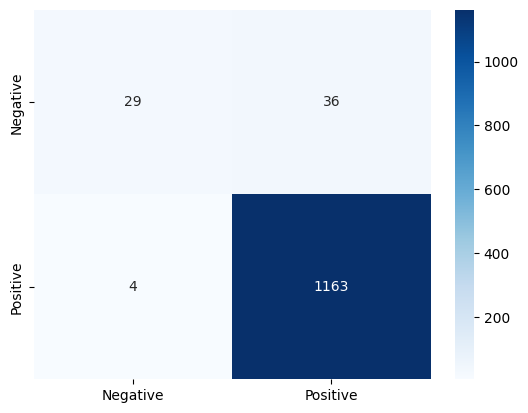

In [ ]:
# Predict the sentiments on the testing set
y_pred_h = xgb.predict(X_test_h_tfv)

# Evaluate the model
# hot
print("Accuracy Score hot:")
print(accuracy_score(y_test_h, y_pred_h))

print("Classification Report hot:")
print(classification_report(y_test_h, y_pred_h))

conf_mat_hot = confusion_matrix(y_test_h, y_pred_h)
sns.heatmap(conf_mat_hot, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

Accuracy Score cold:
0.9728841413311422
Classification Report cold:
              precision    recall  f1-score   support

           0       0.67      0.31      0.42        39
           1       0.98      0.99      0.99      1178

    accuracy                           0.97      1217
   macro avg       0.82      0.65      0.70      1217
weighted avg       0.97      0.97      0.97      1217



<Axes: >

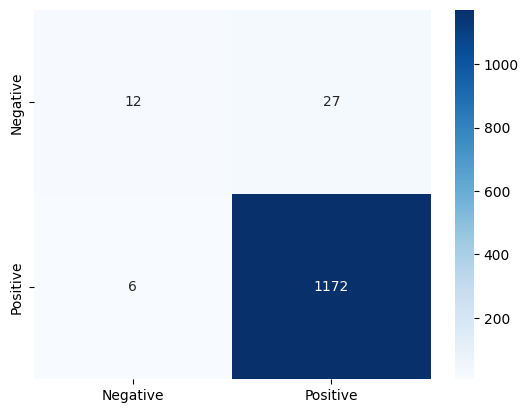

In [ ]:
# Predict the sentiments on the testing set
y_pred_c = xgb.predict(X_test_c_tfv)

# Evaluate the model
# hot
print("Accuracy Score cold:")
print(accuracy_score(y_test_c, y_pred_c))

print("Classification Report cold:")
print(classification_report(y_test_c, y_pred_c))

conf_mat_cold = confusion_matrix(y_test_c, y_pred_c)
sns.heatmap(conf_mat_cold, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

##5.2.2 Hyperparameter tuning

In [ ]:

param_grid = {
    'C': [0.1, 0.5, 1],
    'kernel': ['linear'],
    'class_weight': ['balanced',{0: 5, 1: 1},{0: 7.5, 1: 1},{0: 2, 1: 1}]
}

grid = GridSearchCV(SVC(), param_grid, refit=True,scoring='accuracy', cv=3, verbose=3)
grid.fit(X_train_c_tfv, y_train_c)

print(f"Best parameters found: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END C=0.1, class_weight=balanced, kernel=linear;, score=0.972 total time=   3.0s
[CV 2/3] END C=0.1, class_weight=balanced, kernel=linear;, score=0.983 total time=   5.3s
[CV 3/3] END C=0.1, class_weight=balanced, kernel=linear;, score=0.978 total time=   2.3s
[CV 1/3] END C=0.1, class_weight={0: 5, 1: 1}, kernel=linear;, score=0.980 total time=   1.1s
[CV 2/3] END C=0.1, class_weight={0: 5, 1: 1}, kernel=linear;, score=0.978 total time=   1.1s
[CV 3/3] END C=0.1, class_weight={0: 5, 1: 1}, kernel=linear;, score=0.977 total time=   1.1s
[CV 1/3] END C=0.1, class_weight={0: 7.5, 1: 1}, kernel=linear;, score=0.983 total time=   1.2s
[CV 2/3] END C=0.1, class_weight={0: 7.5, 1: 1}, kernel=linear;, score=0.980 total time=   1.3s
[CV 3/3] END C=0.1, class_weight={0: 7.5, 1: 1}, kernel=linear;, score=0.984 total time=   1.3s
[CV 1/3] END C=0.1, class_weight={0: 2, 1: 1}, kernel=linear;, score=0.968 total time=   0.8s
[CV 2